In [1]:
from pathlib import Path
from tqdm import tqdm_notebook

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import fastai
from fastai.text import *

In [2]:
DATA_PATH = Path('../data')
tqdm_notebook().pandas()

In [3]:
text_cols = ['title', 'text']

In [4]:
train_df = pd.read_csv(DATA_PATH/'train.csv').fillna('<EMPTY>')
valid_df = pd.read_csv(DATA_PATH/'valid.csv').fillna('<EMPTY>')
test_df = pd.read_csv(DATA_PATH/'test.csv', index_col=0).fillna('<EMPTY>')
# unlabeled_df = pd.read_csv(DATA_PATH/'unlabeled.csv', index_col=0).fillna('<EMPTY>')

full_unlabeled_df = pd.concat([train_df[text_cols], valid_df[text_cols], test_df[text_cols]], 
                              axis=0, ignore_index=True)
full_unlabeled_df.to_csv(DATA_PATH/'full_unlabeled.csv', index=False, header=True)

full_train_df = pd.concat([train_df, valid_df], axis=0, ignore_index=True)
full_train_df.to_csv(DATA_PATH/'full_train.csv', index=False, header=True)

test_df.to_csv(DATA_PATH/'full_test.csv', index=False, header=True)

In [5]:
# data_lm.save(DATA_PATH/'data_lm_export.pkl')
data_lm = load_data(DATA_PATH, 'data_lm_export.pkl')

In [6]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3).clip_grad(0.1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-02


0.017378008287493762

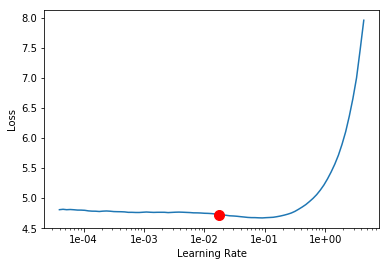

In [12]:
learn.lr_find(start_lr = slice(10e-8, 10e-6), end_lr=slice(0.1, 10))
learn.recorder.plot(suggestion=True)

best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

In [13]:
learn.fit_one_cycle(1, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.146567,3.957749,0.319999,36:06


In [14]:
learn.save('lm_freezed_3')
learn.save_encoder('lm_enc_freezed_3')

In [7]:
learn = learn.load('lm_freezed_3')

In [15]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.94E-04


0.0007943282347242812

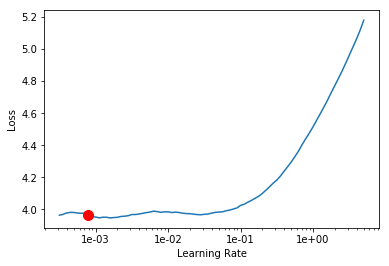

In [16]:
learn.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn.recorder.plot(suggestion=True)

best_lm_lr = learn.recorder.min_grad_lr
best_lm_lr

In [17]:
learn.fit_one_cycle(1, best_lm_lr)

epoch,train_loss,valid_loss,accuracy,time
0,3.747036,3.722839,0.345868,40:23


In [19]:
learn.save('lm_unfreezed_3')
learn.save_encoder('lm_enc_unfreezed_3')

In [7]:
learn = learn.load('lm_unfreezed_3')

In [8]:
data_clas = TextClasDataBunch.from_csv(path=DATA_PATH, 
                                       csv_name='full_train.csv',
                                       test='full_test.csv',
                                       vocab=data_lm.train_ds.vocab, 
                                       bs=16,
                                       text_cols=text_cols, 
                                       label_cols='label')

In [7]:
#data_clas.save(DATA_PATH/'data_clas_export.pkl')
data_clas = load_data(DATA_PATH, 'data_clas_export.pkl', bs=16)

In [7]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM).clip_grad(10)

In [10]:
learn_clas.load_encoder('lm_enc_unfreezed_3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.16E-04


0.000316227766016838

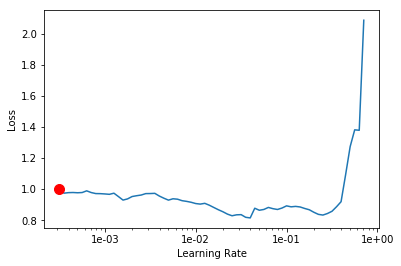

In [11]:
learn_clas.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn_clas.recorder.plot(suggestion=True)

best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

In [12]:
learn_clas.fit_one_cycle(1, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.426264,0.318651,0.874055,57:55


In [14]:
learn_clas.save('clf_freezed_3')

In [8]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)

In [9]:
learn_clas = learn_clas.load('clf_freezed_3')

In [10]:
learn_clas.freeze_to(-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.00E-02


0.019952623149688806

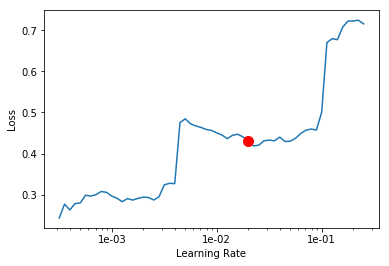

In [11]:
learn_clas.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn_clas.recorder.plot(suggestion=True)

best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

In [ ]:
learn_clas.fit_one_cycle(1, 5e-3)

In [ ]:
learn_clas.save('clf_unfreezed_2_3')

In [6]:
learn_clas = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM).clip_grad(10)

In [7]:
learn_clas = learn_clas.load('clf_unfreezed_2_3')

In [8]:
learn_clas.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.01E-04


0.0005011872336272724

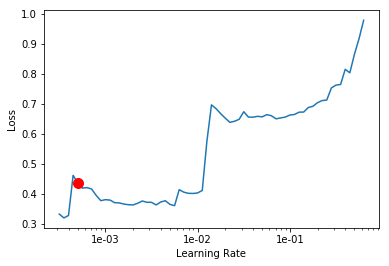

In [9]:
learn_clas.lr_find(start_lr = slice(10e-7, 10e-5), end_lr=slice(0.1, 10))
learn_clas.recorder.plot(suggestion=True)

best_clf_lr = learn_clas.recorder.min_grad_lr
best_clf_lr

In [10]:
learn_clas.fit_one_cycle(1, slice(best_clf_lr/100, best_clf_lr), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.352540,0.324426,0.874230,1:13:31


In [11]:
learn_clas.save('clf_unfreezed_all_3')

In [12]:
learn_clas.show_results()

text,target,prediction
"xxbos xxmaj super xxmaj bowl xxup li xxmaj highlights and xxmaj analysis xxmaj times reporters and editors provided coverage of the xxunk , xxmaj lady xxmaj gaga , and oh yeah , the football game as the xxmaj patriots rallied to defeat the xxmaj falcons in overtime , 34 - 28 . xxup feb . 5 , 2017 xxmaj andrew xxmaj das xxmaj editor xxunk xxup pm xxup et xxmaj",news,news
"xxbos 2017 xxup nfl xxmaj schedule : w - l xxmaj predictions for xxmaj every xxmaj team xxmaj predictions are never an easy task for us football writers . xxmaj not only are we guaranteed to be wrong in some way , but people yell at us — yeah , i 'm talking about you ! "" xxmaj you idiot ! xxmaj there 's no way ( insert favorite team",news,news
xxbos * * xxmaj georgia xxmaj special xxmaj election xxmaj livewire * * xxmaj democrat xxmaj ossoff xxmaj versus xxmaj republican xxmaj handel - xxmaj breitbart xxmaj the polls have closed in xxmaj georgia ’s xxmaj sixth xxmaj congressional district for the special election between xxmaj democrat xxmaj jon xxmaj ossoff and xxmaj republican xxmaj karen xxmaj handel . [ xxmaj the special election has turned out to be the,news,news
"xxbos * * * xxmaj live xxmaj updates * * * xxmaj trump vs. xxmaj clinton , xxmaj round xxmaj one - xxmaj breitbart xxmaj welcome to xxmaj breitbart xxmaj news ’s live updates of the 2016 election . xxmaj donald xxmaj trump and xxmaj hillary xxmaj clinton will finally face off for the first time tonight at xxmaj hofstra xxmaj university at tonight ’s presidential debate . xxmaj stay",news,news
"xxbos xxmaj the xxmaj perfect xxmaj weapon : xxmaj how xxmaj russian xxmaj xxunk xxmaj invaded the xxup u.s. xxup washington — xxmaj when xxmaj special xxmaj agent xxmaj adrian xxmaj hawkins of the xxmaj federal xxmaj bureau of xxmaj investigation called the xxmaj democratic xxmaj national xxmaj committee in xxmaj september 2015 to pass along some troubling news about its computer network , he was transferred , naturally ,",news,news


In [13]:
test_preds = np.concatenate([learn_clas.predict(item=test_df.iloc[i])[2].cpu().numpy().reshape(1, -1)
                            for i in tqdm_notebook(range(len(test_df)))], axis=0)

In [15]:
test_pred_df = pd.DataFrame(test_preds, columns=['clickbait', 'news', 'other'])
ulmfit_preds = pd.Series(np.argmax(test_pred_df.values, axis=1),
                        name='label').map({0: 'clickbait', 1: 'news', 2: 'other'})

In [16]:
test_pred_df.to_csv(DATA_PATH/'test_preds', index=False)

In [17]:
test_pred_df.head()

,clickbait,news,other
0,0.283478,0.653641,0.062882
1,0.405543,0.500396,0.094061
2,0.090231,0.887951,0.021818
3,0.535327,0.463366,0.001308
4,0.235639,0.764355,0.000006


In [18]:
ulmfit_preds.head()

0         news
1         news
2         news
3    clickbait
4         news
Name: label, dtype: object

In [19]:
ulmfit_preds.to_csv('ulmfit_predictions_3.csv', index_label='id', header=True)

In [20]:
!head 'ulmfit_predictions_3.csv'

id,label
0,news
1,news
2,news
3,clickbait
4,news
5,news
6,news
7,news
8,news


In [21]:
!wc -l ulmfit_predictions_3.csv

5648 ulmfit_predictions_3.csv


In [22]:
!kaggle competitions submit -c dlinnlp-spring-2019-clf -f ulmfit_predictions_3.csv -m "ULMFiT Baseline"

100%|██████████████████████████████████████| 56.6k/56.6k [00:01<00:00, 38.0kB/s]
Successfully submitted to DL in NLP Spring 2019. Classification